In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import holidays
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime

In [2]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233


In [3]:
weather_df = pd.read_csv('data/external_data.csv')
weather_df.head(2)

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define a mapping of current column names to more meaningful names
column_mapping = {
    'numer_sta': 'station_id',
    'date': 'date',
    'pmer': 'sea_level_pressure',
    'tend': 'pressure_tendency',
    'cod_tend': 'pressure_tendency_code',
    'dd': 'wind_direction',
    'ff': 'wind_speed',
    't': 'air_temperature',
    'td': 'dew_point_temperature',
    'u': 'relative_humidity',
    'vv': 'visibility',
    'ww': 'current_weather_code',
    'w1': 'past_weather_1',
    'w2': 'past_weather_2',
    'n': 'total_cloud_cover',
    'nbas': 'low_cloud_cover',
    'hbas': 'low_cloud_height',
    'cl': 'low_cloud_type',
    'cm': 'medium_cloud_type',
    'ch': 'high_cloud_type',
    'pres': 'station_pressure',
    'niv_bar': 'barometric_level',
    'geop': 'geopotential_height',
    'tend24': '24hr_pressure_tendency',
    'tn12': '12hr_min_temperature',
    'tn24': '24hr_min_temperature',
    'tx12': '12hr_max_temperature',
    'tx24': '24hr_max_temperature',
    'tminsol': 'min_ground_temperature',
    'sw': 'sunshine_duration',
    'tw': 'wet_bulb_temperature',
    'raf10': '10min_max_wind_gust',
    'rafper': 'period_max_wind_gust',
    'per': 'gust_period_duration',
    'etat_sol': 'ground_state',
    'ht_neige': 'snow_depth',
    'ssfrai': 'fresh_snow_depth',
    'perssfrai': 'snowfall_duration',
    'rr1': '1hr_precipitation',
    'rr3': '3hr_precipitation',
    'rr6': '6hr_precipitation',
    'rr12': '12hr_precipitation',
    'rr24': '24hr_precipitation',
    'phenspe1': 'special_phenomena_1',
    'phenspe2': 'special_phenomena_2',
    'phenspe3': 'special_phenomena_3',
    'phenspe4': 'special_phenomena_4',
    'nnuage1': 'cloud_cover_layer1',
    'ctype1': 'cloud_type_layer1',
    'hnuage1': 'cloud_base_height_layer1',
    'nnuage2': 'cloud_cover_layer2',
    'ctype2': 'cloud_type_layer2',
    'hnuage2': 'cloud_base_height_layer2',
    'nnuage3': 'cloud_cover_layer3',
    'ctype3': 'cloud_type_layer3',
    'hnuage3': 'cloud_base_height_layer3',
    'nnuage4': 'cloud_cover_layer4',
    'ctype4': 'cloud_type_layer4',
    'hnuage4': 'cloud_base_height_layer4'
}

# Rename the columns in the DataFrame
weather_df.rename(columns=column_mapping, inplace=True)

# Display the renamed DataFrame's columns
weather_df.columns

Index(['station_id', 'date', 'sea_level_pressure', 'pressure_tendency',
       'pressure_tendency_code', 'wind_direction', 'wind_speed',
       'air_temperature', 'dew_point_temperature', 'relative_humidity',
       'visibility', 'current_weather_code', 'past_weather_1',
       'past_weather_2', 'total_cloud_cover', 'low_cloud_cover',
       'low_cloud_height', 'low_cloud_type', 'medium_cloud_type',
       'high_cloud_type', 'station_pressure', 'barometric_level',
       'geopotential_height', '24hr_pressure_tendency', '12hr_min_temperature',
       '24hr_min_temperature', '12hr_max_temperature', '24hr_max_temperature',
       'min_ground_temperature', 'sunshine_duration', 'wet_bulb_temperature',
       '10min_max_wind_gust', 'period_max_wind_gust', 'gust_period_duration',
       'ground_state', 'snow_depth', 'fresh_snow_depth', 'snowfall_duration',
       '1hr_precipitation', '3hr_precipitation', '6hr_precipitation',
       '12hr_precipitation', '24hr_precipitation', 'special_phenomen

In [5]:
# Define categories based on column names
categories = {
    "Pressure": [
        "sea_level_pressure", "pressure_tendency", "pressure_tendency_code",
        "station_pressure", "24hr_pressure_tendency", "barometric_level",
        "geopotential_height"
    ],
    "Temperature": [
        "air_temperature", "dew_point_temperature", "relative_humidity",
        "12hr_min_temperature", "12hr_max_temperature", "24hr_min_temperature",
        "24hr_max_temperature", "min_ground_temperature", "wet_bulb_temperature"
    ],
    "Wind": [
        "wind_direction", "wind_speed", "10min_max_wind_gust", "period_max_wind_gust",
        "gust_period_duration"
    ],
    "Precipitation": [
        "1hr_precipitation", "3hr_precipitation", "6hr_precipitation",
        "12hr_precipitation", "24hr_precipitation", "snow_depth",
        "fresh_snow_depth", "snowfall_duration"
    ],
    "Clouds": [
        "total_cloud_cover", "low_cloud_cover", "low_cloud_height", "low_cloud_type",
        "medium_cloud_type", "high_cloud_type", "cloud_cover_layer1",
        "cloud_type_layer1", "cloud_base_height_layer1", "cloud_cover_layer2",
        "cloud_type_layer2", "cloud_base_height_layer2", "cloud_cover_layer3",
        "cloud_type_layer3", "cloud_base_height_layer3", "cloud_cover_layer4",
        "cloud_type_layer4", "cloud_base_height_layer4"
    ],
    "Weather Events": [
        "current_weather_code", "past_weather_1", "past_weather_2",
        "special_phenomena_1", "special_phenomena_2", "special_phenomena_3",
        "special_phenomena_4"
    ]
}


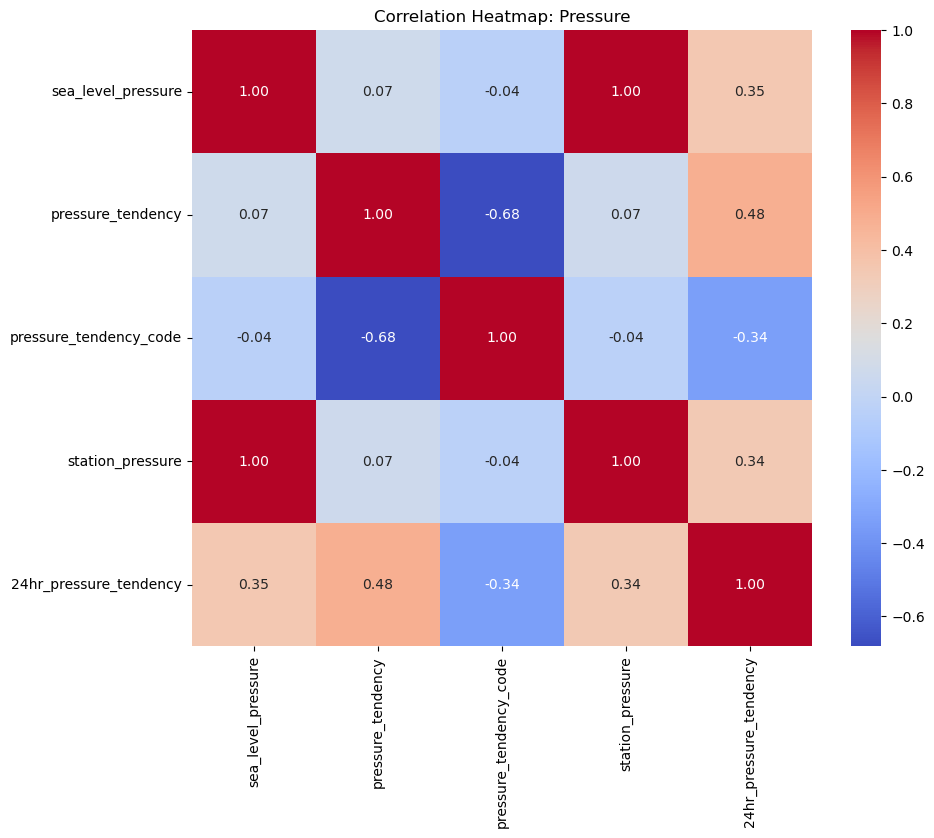

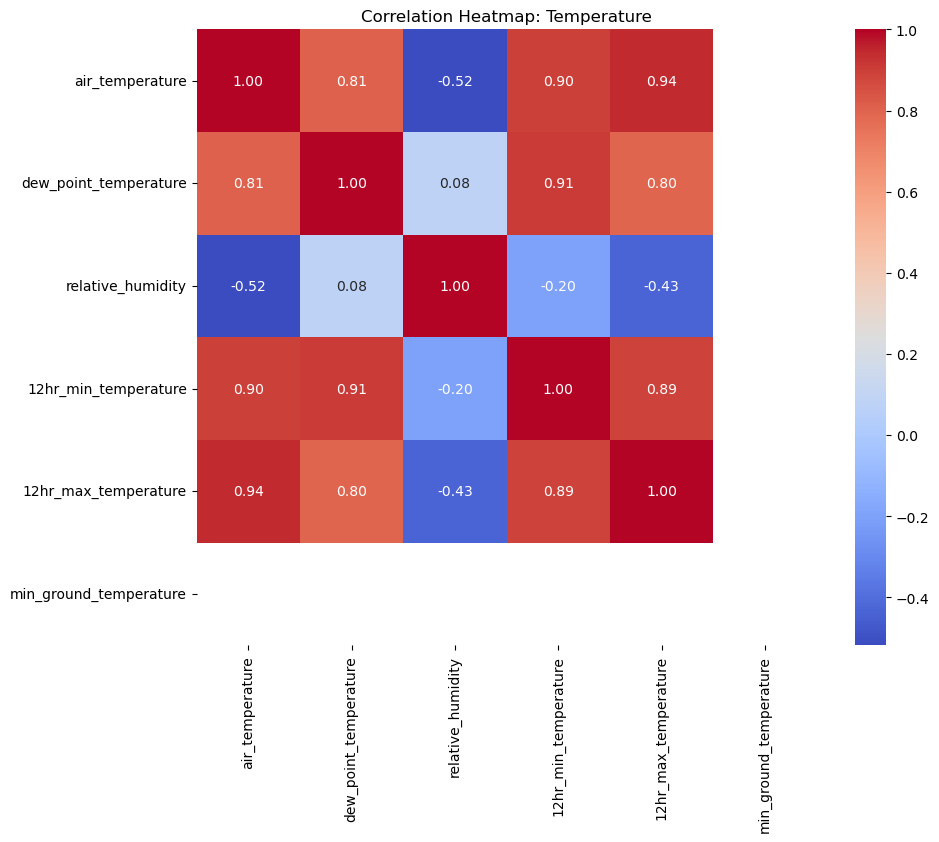

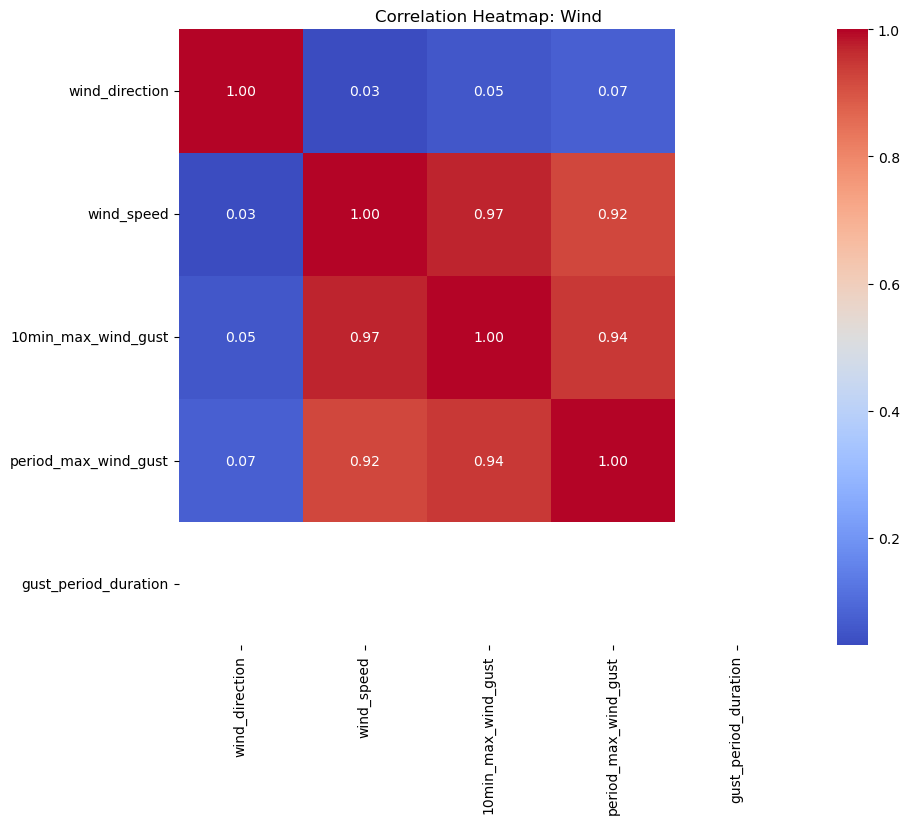

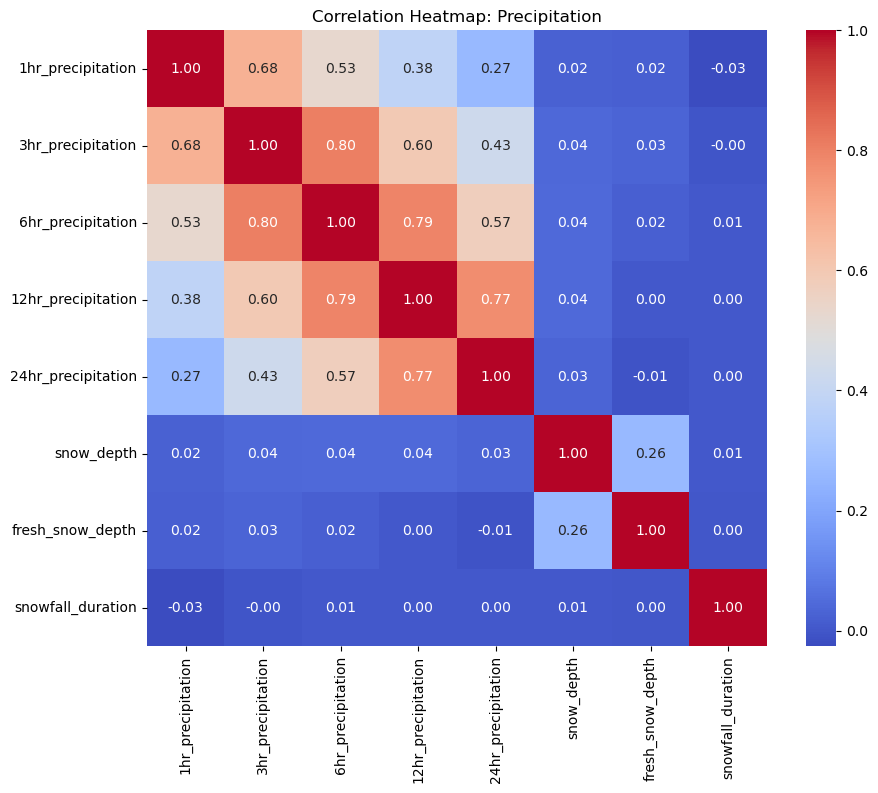

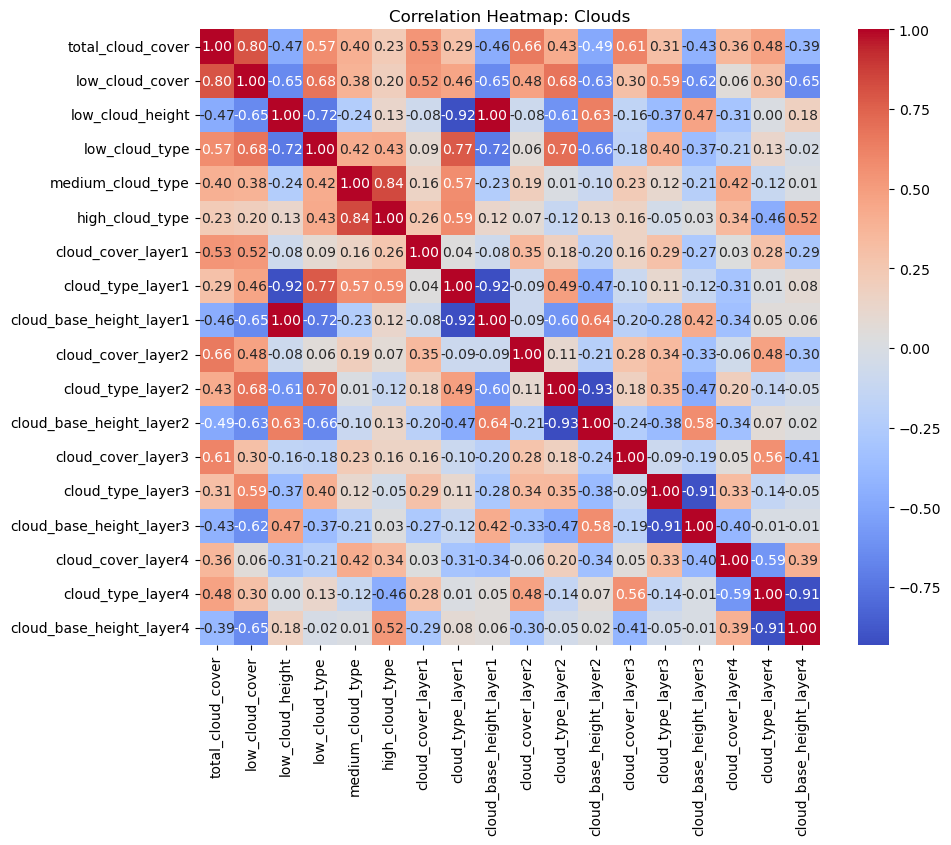

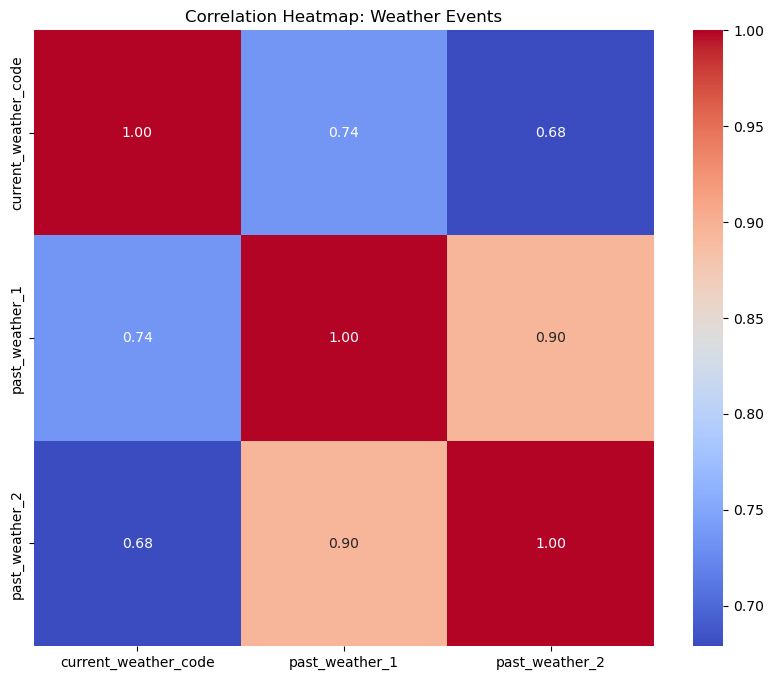

In [6]:
for category, columns in categories.items():
    # Filter the DataFrame for the current category
    category_df = weather_df[columns].dropna(axis=1, how="all")  # Drop columns with all NaN values
    
    # Check if category_df has sufficient data for visualization
    if category_df.empty or category_df.shape[1] < 2:
        print(f"{category}: Not enough data to visualize.")
        continue
    
    # Compute correlation matrix
    corr_matrix = category_df.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Correlation Heatmap: {category}")
    plt.show()


In [7]:
# empty_columns = weather_df.columns[weather_df.isna().all()]

# weather_df.drop(empty_columns, axis=1, inplace=True)

In [8]:
columns_to_keep = [
    "date",
    "relative_humidity",
    "wind_speed",
    "24hr_precipitation",
    "snow_depth",
    "fresh_snow_depth",
    "pressure_tendency",
    "pressure_tendency_code",
    "relative_humidity",
    "station_pressure",
    "1hr_precipitation",
    "3hr_precipitation",
    "6hr_precipitation",
    "12hr_precipitation",
    "24hr_precipitation",
    "visibility",
    'current_weather_code',
    'past_weather_1',
    'past_weather_2',
    'ground_state',
    'low_cloud_cover',
    'low_cloud_height',
    'total_cloud_cover',
    'air_temperature',
    'dew_point_temperature',
    '24hr_pressure_tendency',
    '12hr_min_temperature',
    '24hr_min_temperature'
]

# Keeping only the selected columns
weather_df = weather_df[columns_to_keep]
weather_df[["snow_depth", "fresh_snow_depth", ]] = weather_df[["snow_depth", "fresh_snow_depth"]].fillna(0)

for col in ["1hr_precipitation", "3hr_precipitation", "6hr_precipitation", "12hr_precipitation", "24hr_precipitation", "visibility"]:
    weather_df[col].fillna(weather_df[col].mean(), inplace=True)
    
for column in weather_df[['current_weather_code', 'past_weather_1', 'past_weather_2', 'ground_state']].columns:
    mode = weather_df[column].mode()[0]  
    weather_df[column].fillna(mode, inplace=True)

for col in weather_df[['ground_state', 'low_cloud_cover', 'low_cloud_height', 'total_cloud_cover']].columns:
    if weather_df[col].isna().any():  
        mean_value = weather_df[col].mean(skipna=True) 
        rounded_mean = round(mean_value)  
        weather_df[col].fillna(rounded_mean, inplace=True) 


/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/1949835705.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df[col].fillna(weather_df[col].mean(), inplace=True)
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/1949835705.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df[col].fillna(wea

In [9]:
weather_df['date'] = pd.to_datetime(weather_df['date'])

# X = X.merge(weather_df, on="date", how="left")


In [10]:
X["date"] = X["date"].astype('datetime64[ns]')
weather_df["date"] = weather_df["date"].astype('datetime64[ns]')

In [11]:
def _merge_weather_data(X, weather_df):
    """
    Merge weather data into the main DataFrame X using the date column.
    
    Parameters:
    - X: DataFrame containing the main dataset with a 'date' column.
    - weather_df: DataFrame containing weather data with 'date' and weather attributes.

    Returns:
    - X: Updated DataFrame with merged weather data.
    """
    # Copy X to avoid modifying the original DataFrame
    X = X.copy()
    
    # Convert 'date' to datetime with explicit nanosecond precision
    X["date"] = pd.to_datetime(X["date"]).dt.floor("us")
    weather_df["date"] = pd.to_datetime(weather_df["date"]).dt.floor("us")
    
    # Add an index column to preserve the original order
    X["orig_index"] = np.arange(X.shape[0])
    
    # Sort both DataFrames by 'date' for asof merge
    X = X.sort_values("date")
    weather_df = weather_df.sort_values("date")
    
    # Perform the asof merge on 'date'
    X = pd.merge_asof(
        X,
        weather_df,
        on="date",
        direction="backward"  # Match the nearest preceding weather data
    )
    
    # Restore the original order of X
    X = X.sort_values("orig_index")
    del X["orig_index"]  # Remove the helper column
    
    return X



X = _merge_weather_data(X, weather_df)

In [12]:
# Checking for NaN values in each column of the DataFrame
nan_summary = X.isna().sum().reset_index()
nan_summary.columns = ['Column', 'NaN Count']
nan_summary['NaN Percentage'] = (nan_summary['NaN Count'] / len(X)) * 100
nan_summary


,Column,NaN Count,NaN Percentage
0,counter_id,0,0.000000
1,counter_name,0,0.000000
2,site_id,0,0.000000
3,site_name,0,0.000000
4,date,0,0.000000
5,counter_installation_date,0,0.000000
6,coordinates,0,0.000000
7,counter_technical_id,0,0.000000
8,latitude,0,0.000000
9,longitude,0,0.000000


In [13]:
X['24hr_precipitation'].fillna(0, inplace=True)
X['snow_depth'].fillna(0, inplace=True)

/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/248559459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['24hr_precipitation'].fillna(0, inplace=True)
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/248559459.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['snow_depth'].fillna(0, inplace=True)


In [14]:
# # Sort the DataFrame by 'date'
# X = X.sort_values(by='date')

# # Ensure 'date' is in datetime format
# X['date'] = pd.to_datetime(X['date'])

# # Extract the date part without the time for grouping
# X['date_only'] = X['date'].dt.date

# # Identify columns of type float or int
# numeric_columns = X.select_dtypes(include=['float', 'int']).columns

# # Fill missing values in numeric columns with the average for the same date rows
# for col in numeric_columns:
#     X[col] = X.groupby('date_only')[col].transform(
#         lambda x: x.fillna(x.mean()) if not x.empty else x
#     )

# # Drop the helper 'date_only' column
# X = X.drop(columns=['date_only'])

# # Checking for NaN values in each column of the DataFrame
# nan_summary = X.isna().sum().reset_index()
# nan_summary.columns = ['Column', 'NaN Count']
# nan_summary['NaN Percentage'] = (nan_summary['NaN Count'] / len(X)) * 100
# nan_summary


In [15]:
X.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,past_weather_2,ground_state,low_cloud_cover,low_cloud_height,total_cloud_cover,air_temperature,dew_point_temperature,24hr_pressure_tendency,12hr_min_temperature,24hr_min_temperature
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,0.0,0.0,0.0,2047.0,0.0,285.75,282.55,120.0,NaN,NaN
30,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,0.0,0.0,0.0,2047.0,0.0,285.75,282.55,120.0,NaN,NaN
31,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,0.0,0.0,0.0,2047.0,0.0,285.75,282.55,120.0,NaN,NaN
32,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,0.0,0.0,0.0,2047.0,0.0,285.75,282.55,120.0,NaN,NaN
33,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,0.0,0.0,0.0,2047.0,0.0,285.75,282.55,120.0,NaN,NaN


In [16]:
def _encode_dates(X):
    X = X.copy()  # Modify a copy of X
    
    # Ensure 'date' is in datetime format
    X["date"] = pd.to_datetime(X["date"])
    
    # Extract date components
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Identify weekends (Saturday = 5, Sunday = 6)
    X["is_weekend"] = X["weekday"].isin([5, 6])
    
    # Get French holidays for all years in the dataset
    years = X["year"].unique()
    fr_holidays = holidays.France(years=years)
    
    # Identify holidays
    X["is_holiday"] = X["date"].dt.date.isin(fr_holidays)
    
    # Drop the original 'date' column
    return X


In [17]:
date_encoder = FunctionTransformer(_encode_dates, validate=False)
X = date_encoder.fit_transform(X)
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,24hr_pressure_tendency,12hr_min_temperature,24hr_min_temperature,year,month,day,weekday,hour,is_weekend,is_holiday
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,120.0,NaN,NaN,2020,9,1,1,1,False,False
30,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,120.0,NaN,NaN,2020,9,1,1,1,False,False


In [18]:
# Ensure the 'date' column is in datetime format
X['date'] = pd.to_datetime(X['date'])

# Find the earliest and latest dates
earliest_date = X['date'].min()
latest_date = X['date'].max()

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")


Earliest date: 2020-09-01 01:00:00
Latest date: 2021-09-09 23:00:00


In [19]:
strike_data = {
    'date': [
        datetime(2020, 1, 1), datetime(2020, 1, 2), datetime(2020, 1, 3), datetime(2020, 1, 4),
        datetime(2020, 1, 7), datetime(2020, 1, 8), datetime(2020, 1, 9), datetime(2020, 1, 10),
        datetime(2020, 10, 17), datetime(2020, 10, 18),
        datetime(2021, 2, 4), datetime(2021, 2, 5),
        datetime(2021, 4, 6), datetime(2021, 4, 7),
        datetime(2021, 11, 16), datetime(2021, 11, 17)
    ],
    'Strike': [1] * 16  # Mark all these dates as strike days
}

# Create a DataFrame
strike = pd.DataFrame(strike_data)

# Sort the values by ascending date
strike.sort_values(by='date', inplace=True)
strike.reset_index(drop=True, inplace=True)




In [20]:
# Define lockdown periods
lockdown_periods = [
    (pd.Timestamp("2020-03-17"), pd.Timestamp("2020-05-11")),
    (pd.Timestamp("2020-10-30"), pd.Timestamp("2020-12-15")),
    (pd.Timestamp("2021-04-03"), pd.Timestamp("2021-05-03")),
]

# Function to check if a date falls within any lockdown period
def is_lockdown(date):
    for start, end in lockdown_periods:
        if start <= date <= end:
            return 1
    return 0




In [21]:
def get_TimeOfDay(hour):
  if hour > 3 and hour <= 6:
    return 1  
  if hour > 6 and hour <= 10:
    return 2
  elif hour > 10 and hour <= 13:
    return 3
  elif hour > 13 and hour <= 17:
    return 4
  elif hour > 17 and hour <= 22:
    return 5
  else :
    return 6




from datetime import datetime

# Function to assign seasons for 2020 and 2021
def get_season(date):
    # Define seasons for both years
    if ((date > datetime(2020, 3, 20)) & (date < datetime(2020, 6, 21))) | \
       ((date > datetime(2021, 3, 20)) & (date < datetime(2021, 6, 21))):
        return 1  # Spring
    if ((date > datetime(2020, 6, 20)) & (date < datetime(2020, 9, 21))) | \
       ((date > datetime(2021, 6, 20)) & (date < datetime(2021, 9, 21))):
        return 2  # Summer
    if ((date > datetime(2020, 9, 20)) & (date < datetime(2020, 12, 21))) | \
       ((date > datetime(2021, 9, 20)) & (date < datetime(2021, 12, 21))):
        return 3  # Fall
    if ((date > datetime(2020, 12, 20)) & (date < datetime(2021, 3, 20))) | \
       ((date > datetime(2019, 12, 31)) & (date < datetime(2020, 3, 21))) | \
       ((date > datetime(2021, 12, 20)) & (date < datetime(2022, 3, 21))):
        return 4  # Winter
    else:
       return 5





In [22]:
# Merge the strike DataFrame with another DataFrame (X)
X = X.merge(strike, on='date', how='left')
X['Strike'] = X['Strike'].fillna(0).astype(int)
# Apply the function to the date column
X["Covid"] = X["date"].apply(is_lockdown)
#Create columns by applying the functions
X['TimeOfDay'] = X['hour'].apply(get_TimeOfDay)
# Apply the function to the 'date' column
X['Season'] = X['date'].apply(get_season)

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496827 entries, 0 to 496826
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   date                       496827 non-null  datetime64[ns]
 5   counter_installation_date  496827 non-null  datetime64[us]
 6   coordinates                496827 non-null  category      
 7   counter_technical_id       496827 non-null  category      
 8   latitude                   496827 non-null  float64       
 9   longitude                  496827 non-null  float64       
 10  relative_humidity          496827 non-null  int64         
 11  wind_speed                 496827 non-null  float64 

In [24]:
columns_to_drop = [
    "counter_technical_id", 
    "coordinates", 
    "counter_installation_date", 
    "site_id", 
    "site_name", 
    "counter_name"
]

# Drop columns from the DataFrame
X = X.drop(columns=columns_to_drop)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496827 entries, 0 to 496826
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   counter_id              496827 non-null  category      
 1   date                    496827 non-null  datetime64[ns]
 2   latitude                496827 non-null  float64       
 3   longitude               496827 non-null  float64       
 4   relative_humidity       496827 non-null  int64         
 5   wind_speed              496827 non-null  float64       
 6   24hr_precipitation      493815 non-null  float64       
 7   snow_depth              496827 non-null  float64       
 8   fresh_snow_depth        496827 non-null  float64       
 9   pressure_tendency       496827 non-null  int64         
 10  pressure_tendency_code  496827 non-null  int64         
 11  relative_humidity       496827 non-null  int64         
 12  station_pressure        496827

In [25]:
# # Drop rows with NaN values
# X.dropna(inplace=True)

# # Drop duplicate rows
# X.drop_duplicates(inplace=True)

# # Reset index for a cleaner DataFrame
X.reset_index(drop=True, inplace=True)

# # Check the updated DataFrame
# X.info()

In [26]:
# X = pd.get_dummies(X, columns=["hour"], prefix="hour")
# X.head(2)


In [27]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [28]:
# Step 1: Preprocessing
# One-hot encode the categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_encoded = onehot_encoder.fit_transform(X[categorical_cols])

# Numerical scaling
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(X[numerical_cols])

# Drop processed columns
X.drop(categorical_cols, axis=1, inplace=True)
X.drop(numerical_cols, axis=1, inplace=True)

# Ensure date column is in datetime format
X["date"] = pd.to_datetime(X["date"])

# Combine all features
X_combined = np.hstack([X.values, categorical_encoded, numerical_scaled])

# Assuming each sample has a single timestep

# Step 3: Temporal Train-Test Split
# Convert X_reshaped back into a DataFrame to preserve the date column
X_combined_df = pd.DataFrame(X_combined, columns=[f"feature_{i}" for i in range(X_combined.shape[1])])
X_combined_df["date"] = X["date"].values  # Restore the date column


# Apply temporal train-test split
X_train_split, y_train_split, X_test_split, y_test_split = train_test_split_temporal(X_combined_df, y)


# Remove the 'date' column after splitting
datetime_columns = X_test_split.select_dtypes(include=['datetime64[ns]']).columns
print(f"Columns with datetime64[ns] dtype: {datetime_columns.tolist()}")
datetime_columns = X_test_split.select_dtypes(include=['datetime64[ns]']).columns
print(f"Columns with datetime64[ns] dtype: {datetime_columns.tolist()}")

# Drop these columns from X_train_split
X_train_split = X_train_split.drop(columns=datetime_columns)
# Drop these columns from X_test_split
X_test_split = X_test_split.drop(columns=datetime_columns)

X_train_split = X_train_split.astype(float)
X_test_split = X_test_split.astype(float)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:701: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:718: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Columns with datetime64[ns] dtype: ['feature_0', 'date']
Columns with datetime64[ns] dtype: ['feature_0', 'date']


In [29]:
X_train_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456507 entries, 0 to 456506
Data columns (total 100 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   feature_1    456507 non-null  float64
 1   feature_2    456507 non-null  float64
 2   feature_3    456507 non-null  float64
 3   feature_4    456507 non-null  float64
 4   feature_5    456507 non-null  float64
 5   feature_6    456507 non-null  float64
 6   feature_7    456507 non-null  float64
 7   feature_8    456507 non-null  float64
 8   feature_9    456507 non-null  float64
 9   feature_10   456507 non-null  float64
 10  feature_11   456507 non-null  float64
 11  feature_12   456507 non-null  float64
 12  feature_13   456507 non-null  float64
 13  feature_14   456507 non-null  float64
 14  feature_15   456507 non-null  float64
 15  feature_16   456507 non-null  float64
 16  feature_17   456507 non-null  float64
 17  feature_18   456507 non-null  float64
 18  feature_19   456507 non-null

In [30]:
final_test = utils.get_test_data()
original_index = final_test.index

date_encoder = FunctionTransformer(_encode_dates, validate=False)
final_test = date_encoder.fit_transform(final_test)

# weather = pd.read_csv(
#     "H_75_previous-2020-2022.csv",
#     parse_dates=["AAAAMMJJHH"],
#     date_format="%Y%m%d%H",
#     sep=";",
# ).rename(columns={"AAAAMMJJHH": "date"})

# weather = weather[
#     (weather["date"] >= final_test["date"].min())
#     & (weather["date"] <= final_test["date"].max())
# ]

# weather_reduced = (
#     weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
#     .groupby("date")
#     .mean()
#     .dropna(axis=1, how="all")
#     .interpolate(method="linear")
# )

# weather_reduced["is_rain"] = (weather_reduced["RR1"] > 0).astype(int)

# final_test["orig_index"] = final_test.index

# Merge and restore the original index
# final_test = final_test.merge(weather_reduced, on="date", how="left")
# final_test.set_index("orig_index", inplace=True)

# Output
# Merge the strike DataFrame with another DataFrame (X)
final_test = final_test.merge(strike, on='date', how='left')
final_test['Strike'] = final_test['Strike'].fillna(0).astype(int)
# Apply the function to the date column
final_test["Covid"] = final_test["date"].apply(is_lockdown)
#Create columns by applying the functions
final_test['TimeOfDay'] = final_test['hour'].apply(get_TimeOfDay)
# Apply the function to the 'date' column
final_test['Season'] = final_test['date'].apply(get_season)

final_test.head()


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,month,day,weekday,hour,is_weekend,is_holiday,Strike,Covid,TimeOfDay,Season
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2021-09-10 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,9,10,4,1,False,False,0,0,6,2
1,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2021-09-10 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,9,10,4,1,False,False,0,0,6,2
2,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2021-09-10 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,9,10,4,1,False,False,0,0,6,2
3,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2021-09-10 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,9,10,4,1,False,False,0,0,6,2
4,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2021-09-10 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,9,10,4,1,False,False,0,0,6,2


In [31]:
columns_to_drop = [
    "counter_technical_id", 
    "coordinates", 
    "counter_installation_date", 
    "site_id", 
    "site_name", 
    "counter_name"
]

# Drop columns from the DataFrame
final_test = final_test.drop(columns=columns_to_drop)

final_test["date"] = final_test["date"].astype('datetime64[ns]')

final_test = _merge_weather_data(final_test, weather_df)


# final_test = final_test.merge(weather_df, on="date", how="left")
# # Sort the DataFrame by 'date'
# final_test = final_test.sort_values(by='date')

# # Ensure 'date' is in datetime format
# final_test['date'] = pd.to_datetime(X['date'])

# # Extract the date part without the time for grouping
# final_test['date_only'] = final_test['date'].dt.date

# # Identify columns of type float or int
# numeric_columns = final_test.select_dtypes(include=['float', 'int']).columns

# # Fill missing values in numeric columns with the average for the same date rows
# for col in numeric_columns:
#     final_test[col] = final_test.groupby('date_only')[col].transform(
#         lambda x: x.fillna(x.mean()) if not x.empty else x
#     )

# Drop the helper 'date_only' column
# final_test = final_test.drop(columns=['date_only'])
final_test['24hr_precipitation'].fillna(0, inplace=True)
final_test['snow_depth'].fillna(0, inplace=True)
final_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51440 entries, 0 to 51439
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   counter_id              51440 non-null  category      
 1   date                    51440 non-null  datetime64[ns]
 2   latitude                51440 non-null  float64       
 3   longitude               51440 non-null  float64       
 4   year                    51440 non-null  int32         
 5   month                   51440 non-null  int32         
 6   day                     51440 non-null  int32         
 7   weekday                 51440 non-null  int32         
 8   hour                    51440 non-null  int32         
 9   is_weekend              51440 non-null  bool          
 10  is_holiday              51440 non-null  bool          
 11  Strike                  51440 non-null  int64         
 12  Covid                   51440 non-null  int64      

/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3271433296.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test['24hr_precipitation'].fillna(0, inplace=True)
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3271433296.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_test['snow_depth'].filln

In [32]:

# One-hot encode the categorical variables
categorical_cols = final_test.select_dtypes(include=['object', 'category']).columns
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_encoded = onehot_encoder.fit_transform(final_test[categorical_cols])

# Numerical scaling
numerical_cols = final_test.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(final_test[numerical_cols])

# Drop processed columns
final_test.drop(categorical_cols, axis=1, inplace=True)
final_test.drop(numerical_cols, axis=1, inplace=True)

# Ensure the 'date' column is in datetime format
final_test["date"] = pd.to_datetime(final_test["date"])

# Combine all features
final_test_combined = np.hstack([final_test.values, categorical_encoded, numerical_scaled])

# Convert final_test_combined back into a DataFrame
final_test_combined = pd.DataFrame(final_test_combined, columns=[f"feature_{i}" for i in range(final_test_combined.shape[1])])

# Restore the 'date' column and original index
final_test_combined["date"] = final_test["date"].values
final_test_combined.index = original_index  # Set the original index

# Drop 'date' column after restoring
datetime_columns = final_test_combined.select_dtypes(include=['datetime64[ns]']).columns
print(f"Columns with datetime64[ns] dtype: {datetime_columns.tolist()}")

# Drop datetime columns
final_test_combined = final_test_combined.drop(columns=datetime_columns)

# Ensure all columns are numeric
final_test_combined = final_test_combined.astype(float)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:701: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:718: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Columns with datetime64[ns] dtype: ['feature_0', 'date']


In [33]:
final_test_combined.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100
17081,2021.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.125,0.5,1.0,0.664141,1.0,0.659091,0.837349,0.5,NaN,NaN
18655,2021.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.125,0.5,1.0,0.664141,1.0,0.659091,0.837349,0.5,NaN,NaN
3124,2021.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.125,0.5,1.0,0.664141,1.0,0.659091,0.837349,0.5,NaN,NaN
4147,2021.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.125,0.5,1.0,0.664141,1.0,0.659091,0.837349,0.5,NaN,NaN
48210,2021.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.125,0.5,1.0,0.664141,1.0,0.659091,0.837349,0.5,NaN,NaN


In [34]:
models = {
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=1),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    # "Random Forest": RandomForestRegressor(
    #     n_estimators=100,  # Fewer trees
    #     max_depth=20,     # Limit depth
    #     min_samples_split=5,
    #     min_samples_leaf=2,
    #     random_state=42,
    #     n_jobs=-1         # Utilize multiple cores
    # ),
}

# Initialize a dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_split, y_train_split)

    # Predict on the test set
    y_pred = model.predict(X_test_split)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    results[name] = rmse
    print(f"Model: {name}, RMSE: {rmse}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE']).sort_values(by='RMSE')

# Display the results
print(results_df)

for name, model in models.items():
    predictions = model.predict(final_test_combined)
    submission = pd.DataFrame({"id": original_index, "log_bike_count": predictions.flatten()})
    submission_path = f"submission_{name}.csv"
    submission.to_csv(submission_path, index=False)

Model: XGBoost, RMSE: 0.48514736590029856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868
Model: LightGBM, RMSE: 0.48618539648025905
              RMSE
XGBoost   0.485147
LightGBM  0.486185


In [43]:
import optuna
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb

# Define the objective function for XGBoost
def objective_xgb(trial):
    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_test_split)
    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    return rmse

# Define the objective function for LightGBM
def objective_lgb(trial):
    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_test_split)
    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    return rmse

# Run optimization for XGBoost
print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=50)
print(f"Best parameters for XGBoost: {study_xgb.best_params}")
print(f"Best RMSE for XGBoost: {study_xgb.best_value}")

# Run optimization for LightGBM
print("Optimizing LightGBM...")
study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=50)
print(f"Best parameters for LightGBM: {study_lgb.best_params}")
print(f"Best RMSE for LightGBM: {study_lgb.best_value}")

# Train final models with best parameters
final_models = {
    "XGBoost": xgb.XGBRegressor(**study_xgb.best_params, random_state=42, verbosity=0),
    "LightGBM": lgb.LGBMRegressor(**study_lgb.best_params, random_state=42),
}

# Evaluate final models and create submissions
results = {}
for name, model in final_models.items():
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_test_split)
    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    results[name] = rmse
    print(f"Model: {name}, RMSE: {rmse}")

    # Predictions on final test set
    predictions = model.predict(final_test_combined)
    submission = pd.DataFrame({"id": original_index, "log_bike_count": predictions.flatten()})
    submission_path = f"submission_{name}_optuna.csv"
    submission.to_csv(submission_path, index=False)
    print(f"Submission file saved for model: {name}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE']).sort_values(by='RMSE')
print("\nFinal Results:")
print(results_df)


[I 2024-12-10 13:58:53,156] A new study created in memory with name: no-name-db282b67-3cea-4579-9283-848c80effa92


Optimizing XGBoost...


/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_un

Best parameters for XGBoost: {'learning_rate': 0.08870073509214906, 'max_depth': 8, 'n_estimators': 484, 'subsample': 0.7330131306141017, 'colsample_bytree': 0.7930929827633967}
Best RMSE for XGBoost: 0.4282056521050165
Optimizing LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:36,577] Trial 0 finished with value: 0.5432715629970725 and parameters: {'learning_rate': 0.012642341586188335, 'num_leaves': 59, 'n_estimators': 299, 'min_child_samples': 10, 'subsample': 0.9056942393575038, 'colsample_bytree': 0.5498208135027489}. Best is trial 0 with value: 0.5432715629970725.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:40,766] Trial 1 finished with value: 0.458238230130523 and parameters: {'learning_rate': 0.01558089683382031, 'num_leaves': 73, 'n_estimators': 436, 'min_child_samples': 41, 'subsample': 0.5422164864524768, 'colsample_bytree': 0.7588817368536824}. Best is trial 1 with value: 0.458238230130523.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5,

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:46,013] Trial 2 finished with value: 0.4235716115285767 and parameters: {'learning_rate': 0.16296096097421164, 'num_leaves': 75, 'n_estimators': 456, 'min_child_samples': 32, 'subsample': 0.6930626229372376, 'colsample_bytree': 0.9020460598041415}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:47,168] Trial 3 finished with value: 0.5208733584088345 and parameters: {'learning_rate': 0.03591458731743634, 'num_leaves': 48, 'n_estimators': 127, 'min_child_samples': 47, 'subsample': 0.681419392702246, 'colsample_bytree': 0.969466634333125}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5,

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:48,473] Trial 4 finished with value: 0.44678925287610066 and parameters: {'learning_rate': 0.1184975661128409, 'num_leaves': 58, 'n_estimators': 160, 'min_child_samples': 20, 'subsample': 0.5851483022830481, 'colsample_bytree': 0.6476604271333236}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:49,352] Trial 5 finished with value: 0.5259198820208195 and parameters: {'learning_rate': 0.21552719632381992, 'num_leaves': 18, 'n_estimators': 176, 'min_child_samples': 41, 'subsample': 0.9702068243344819, 'colsample_bytree': 0.5679536318765819}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:49,744] Trial 6 finished with value: 0.6955885344455743 and parameters: {'learning_rate': 0.07664608516907967, 'num_leaves': 10, 'n_estimators': 52, 'min_child_samples': 38, 'subsample': 0.6635047552384744, 'colsample_bytree': 0.5547667904969555}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:52,892] Trial 7 finished with value: 0.43665345105440595 and parameters: {'learning_rate': 0.05605753035153581, 'num_leaves': 73, 'n_estimators': 398, 'min_child_samples': 32, 'subsample': 0.9167442963210681, 'colsample_bytree': 0.9329733766545399}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:54,674] Trial 8 finished with value: 0.43931907627651734 and parameters: {'learning_rate': 0.059132045991821716, 'num_leaves': 79, 'n_estimators': 166, 'min_child_samples': 39, 'subsample': 0.8519370531918018, 'colsample_bytree': 0.8724423410894722}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:02:58,498] Trial 9 finished with value: 0.431977365446684 and parameters: {'learning_rate': 0.030745673923986108, 'num_leaves': 61, 'n_estimators': 482, 'min_child_samples': 49, 'subsample': 0.9824334325879513, 'colsample_bytree': 0.7496756377424743}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:01,112] Trial 10 finished with value: 0.4556855284109391 and parameters: {'learning_rate': 0.29514090469040055, 'num_leaves': 97, 'n_estimators': 357, 'min_child_samples': 24, 'subsample': 0.8061474856961572, 'colsample_bytree': 0.8164500851589324}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:04,338] Trial 11 finished with value: 0.4571533201765187 and parameters: {'learning_rate': 0.024981327048348035, 'num_leaves': 38, 'n_estimators': 493, 'min_child_samples': 49, 'subsample': 0.7415584932595398, 'colsample_bytree': 0.6891306351487235}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:07,858] Trial 12 finished with value: 0.434452351713487 and parameters: {'learning_rate': 0.1255155917370543, 'num_leaves': 81, 'n_estimators': 490, 'min_child_samples': 30, 'subsample': 0.9960346625384322, 'colsample_bytree': 0.8204912140241016}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:11,417] Trial 13 finished with value: 0.43250666397553483 and parameters: {'learning_rate': 0.03226088582972204, 'num_leaves': 96, 'n_estimators': 319, 'min_child_samples': 17, 'subsample': 0.7527164166810605, 'colsample_bytree': 0.71999787564102}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:14,323] Trial 14 finished with value: 0.4261216280386138 and parameters: {'learning_rate': 0.1363383227214278, 'num_leaves': 41, 'n_estimators': 428, 'min_child_samples': 32, 'subsample': 0.6587099065955313, 'colsample_bytree': 0.8937243344287045}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:16,684] Trial 15 finished with value: 0.4646733627826475 and parameters: {'learning_rate': 0.1480504197876131, 'num_leaves': 32, 'n_estimators': 406, 'min_child_samples': 30, 'subsample': 0.6321049395267625, 'colsample_bytree': 0.9124036181174107}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:18,849] Trial 16 finished with value: 0.4378019038731319 and parameters: {'learning_rate': 0.09431962207987556, 'num_leaves': 43, 'n_estimators': 253, 'min_child_samples': 34, 'subsample': 0.5131869306646397, 'colsample_bytree': 0.981678963462436}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:21,364] Trial 17 finished with value: 0.43110907906370177 and parameters: {'learning_rate': 0.17391198141667294, 'num_leaves': 29, 'n_estimators': 434, 'min_child_samples': 26, 'subsample': 0.7290264658580929, 'colsample_bytree': 0.8582015656279955}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:23,413] Trial 18 finished with value: 0.45090171201130497 and parameters: {'learning_rate': 0.2973839397992047, 'num_leaves': 50, 'n_estimators': 232, 'min_child_samples': 35, 'subsample': 0.5968317063017619, 'colsample_bytree': 0.9209689240998967}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:26,125] Trial 19 finished with value: 0.42768563633560347 and parameters: {'learning_rate': 0.2049502057043748, 'num_leaves': 69, 'n_estimators': 349, 'min_child_samples': 26, 'subsample': 0.6908482590780246, 'colsample_bytree': 0.8249046546117801}. Best is trial 2 with value: 0.4235716115285767.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:29,567] Trial 20 finished with value: 0.42292719052932104 and parameters: {'learning_rate': 0.08429461598116787, 'num_leaves': 87, 'n_estimators': 380, 'min_child_samples': 20, 'subsample': 0.7964929197950977, 'colsample_bytree': 0.8763221866079517}. Best is trial 20 with value: 0.42292719052932104.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample"

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:33,062] Trial 21 finished with value: 0.4227783352836333 and parameters: {'learning_rate': 0.09585288338252039, 'num_leaves': 90, 'n_estimators': 375, 'min_child_samples': 15, 'subsample': 0.7993999265366828, 'colsample_bytree': 0.8770004828737313}. Best is trial 21 with value: 0.4227783352836333.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:36,720] Trial 22 finished with value: 0.4376942731855215 and parameters: {'learning_rate': 0.0808104987912558, 'num_leaves': 89, 'n_estimators': 358, 'min_child_samples': 14, 'subsample': 0.8005550294034536, 'colsample_bytree': 0.791626349062358}. Best is trial 21 with value: 0.4227783352836333.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:40,233] Trial 23 finished with value: 0.4210710478178664 and parameters: {'learning_rate': 0.09857230963693143, 'num_leaves': 87, 'n_estimators': 383, 'min_child_samples': 20, 'subsample': 0.8439565696531109, 'colsample_bytree': 0.947175546490351}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:44,923] Trial 24 finished with value: 0.4416733388922467 and parameters: {'learning_rate': 0.10010360146099248, 'num_leaves': 88, 'n_estimators': 391, 'min_child_samples': 21, 'subsample': 0.836402054963664, 'colsample_bytree': 0.9691226374395661}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:49,061] Trial 25 finished with value: 0.4297561353784502 and parameters: {'learning_rate': 0.04296563063762554, 'num_leaves': 85, 'n_estimators': 316, 'min_child_samples': 13, 'subsample': 0.8849796819365456, 'colsample_bytree': 0.8599742344985823}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:52,631] Trial 26 finished with value: 0.4264062783776632 and parameters: {'learning_rate': 0.0663687558163524, 'num_leaves': 100, 'n_estimators': 280, 'min_child_samples': 16, 'subsample': 0.7858211453006776, 'colsample_bytree': 0.9991996518077538}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:03:57,035] Trial 27 finished with value: 0.4317694230581701 and parameters: {'learning_rate': 0.046384020018591945, 'num_leaves': 92, 'n_estimators': 372, 'min_child_samples': 20, 'subsample': 0.852431663361237, 'colsample_bytree': 0.9426260663657592}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:00,092] Trial 28 finished with value: 0.43332817403877877 and parameters: {'learning_rate': 0.10066871507609618, 'num_leaves': 65, 'n_estimators': 332, 'min_child_samples': 10, 'subsample': 0.9394977251336897, 'colsample_bytree': 0.8470843740540348}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample",

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:03,061] Trial 29 finished with value: 0.4334332789993246 and parameters: {'learning_rate': 0.07423309777616854, 'num_leaves': 82, 'n_estimators': 273, 'min_child_samples': 10, 'subsample': 0.8754472611741173, 'colsample_bytree': 0.7820215534219572}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:06,034] Trial 30 finished with value: 0.4807356572451746 and parameters: {'learning_rate': 0.020338525584146002, 'num_leaves': 93, 'n_estimators': 224, 'min_child_samples': 23, 'subsample': 0.7732428213241828, 'colsample_bytree': 0.883509614652098}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:09,416] Trial 31 finished with value: 0.4285498814882876 and parameters: {'learning_rate': 0.1543320788044034, 'num_leaves': 75, 'n_estimators': 451, 'min_child_samples': 18, 'subsample': 0.7180095631180375, 'colsample_bytree': 0.9450821529132813}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:16,343] Trial 32 finished with value: 0.4801123223909 and parameters: {'learning_rate': 0.010703694199275044, 'num_leaves': 77, 'n_estimators': 457, 'min_child_samples': 26, 'subsample': 0.8203060207243992, 'colsample_bytree': 0.9013028719550404}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:19,491] Trial 33 finished with value: 0.4524299253627159 and parameters: {'learning_rate': 0.19774048438614614, 'num_leaves': 85, 'n_estimators': 408, 'min_child_samples': 15, 'subsample': 0.7640401271983188, 'colsample_bytree': 0.5073709566874278}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:23,292] Trial 34 finished with value: 0.4416552177827141 and parameters: {'learning_rate': 0.10838676544227041, 'num_leaves': 69, 'n_estimators': 381, 'min_child_samples': 22, 'subsample': 0.7017387369494779, 'colsample_bytree': 0.961267307619503}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:26,834] Trial 35 finished with value: 0.4348494149196565 and parameters: {'learning_rate': 0.0910963189404054, 'num_leaves': 89, 'n_estimators': 423, 'min_child_samples': 12, 'subsample': 0.8867712234861616, 'colsample_bytree': 0.9066713582379424}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:30,918] Trial 36 finished with value: 0.4345020742796082 and parameters: {'learning_rate': 0.12260104974914687, 'num_leaves': 100, 'n_estimators': 468, 'min_child_samples': 18, 'subsample': 0.820348384223364, 'colsample_bytree': 0.6086075259778718}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:32,857] Trial 37 finished with value: 0.43836363185494626 and parameters: {'learning_rate': 0.23939945984470345, 'num_leaves': 55, 'n_estimators': 297, 'min_child_samples': 19, 'subsample': 0.9339138657791071, 'colsample_bytree': 0.8471668190231302}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample",

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:36,660] Trial 38 finished with value: 0.4378644557510082 and parameters: {'learning_rate': 0.04802983038187087, 'num_leaves': 70, 'n_estimators': 439, 'min_child_samples': 28, 'subsample': 0.6125622081544444, 'colsample_bytree': 0.9948265323810803}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:39,770] Trial 39 finished with value: 0.4457207276440141 and parameters: {'learning_rate': 0.06485972469152916, 'num_leaves': 80, 'n_estimators': 337, 'min_child_samples': 43, 'subsample': 0.7826239485058295, 'colsample_bytree': 0.9479345147004672}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:40,817] Trial 40 finished with value: 0.45953885349057244 and parameters: {'learning_rate': 0.08290562495615737, 'num_leaves': 94, 'n_estimators': 74, 'min_child_samples': 24, 'subsample': 0.6635708978262147, 'colsample_bytree': 0.7649874987505725}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:43,697] Trial 41 finished with value: 0.4496134889174607 and parameters: {'learning_rate': 0.14469069669423834, 'num_leaves': 24, 'n_estimators': 411, 'min_child_samples': 33, 'subsample': 0.646133881642727, 'colsample_bytree': 0.8984417640163098}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:46,703] Trial 42 finished with value: 0.43293726036066754 and parameters: {'learning_rate': 0.12317633097047816, 'num_leaves': 50, 'n_estimators': 372, 'min_child_samples': 36, 'subsample': 0.5464733303418223, 'colsample_bytree': 0.883759449446556}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:49,749] Trial 43 finished with value: 0.4295358621345157 and parameters: {'learning_rate': 0.16965536106548154, 'num_leaves': 63, 'n_estimators': 471, 'min_child_samples': 38, 'subsample': 0.6675365517005767, 'colsample_bytree': 0.9268489189262674}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:52,230] Trial 44 finished with value: 0.43942854719389857 and parameters: {'learning_rate': 0.13558015075174906, 'num_leaves': 43, 'n_estimators': 435, 'min_child_samples': 31, 'subsample': 0.7144543640263697, 'colsample_bytree': 0.8798313409383023}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample",

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:55,789] Trial 45 finished with value: 0.42640069170986117 and parameters: {'learning_rate': 0.07227448808658091, 'num_leaves': 85, 'n_estimators': 390, 'min_child_samples': 29, 'subsample': 0.8538273431796347, 'colsample_bytree': 0.8370558610453809}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample",

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:04:58,822] Trial 46 finished with value: 0.4737832866881636 and parameters: {'learning_rate': 0.23737103516164706, 'num_leaves': 73, 'n_estimators': 456, 'min_child_samples': 43, 'subsample': 0.5696070140009483, 'colsample_bytree': 0.8034206312578679}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:05:01,152] Trial 47 finished with value: 0.4306146884101747 and parameters: {'learning_rate': 0.11018747183327504, 'num_leaves': 36, 'n_estimators': 419, 'min_child_samples': 33, 'subsample': 0.7512299042729328, 'colsample_bytree': 0.6853180316187881}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:05:03,948] Trial 48 finished with value: 0.4266587653832982 and parameters: {'learning_rate': 0.17699878783509776, 'num_leaves': 82, 'n_estimators': 363, 'min_child_samples': 28, 'subsample': 0.7316154498317301, 'colsample_bytree': 0.9261171854272721}. Best is trial 23 with value: 0.4210710478178664.
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/q_/t0vvj4pn7l9bcb6_mjhmgg080000gn/T/ipykernel_10084/3892379934.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868


[I 2024-12-10 14:05:07,395] Trial 49 finished with value: 0.4273959887944843 and parameters: {'learning_rate': 0.05966563465284069, 'num_leaves': 56, 'n_estimators': 493, 'min_child_samples': 36, 'subsample': 0.6816802827053823, 'colsample_bytree': 0.8677426122296777}. Best is trial 23 with value: 0.4210710478178664.


Best parameters for LightGBM: {'learning_rate': 0.09857230963693143, 'num_leaves': 87, 'n_estimators': 383, 'min_child_samples': 20, 'subsample': 0.8439565696531109, 'colsample_bytree': 0.947175546490351}
Best RMSE for LightGBM: 0.4210710478178664
Model: XGBoost, RMSE: 0.4282056521050165
Submission file saved for model: XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868
Model: LightGBM, RMSE: 0.4210710478178664
Submission file saved for model: LightGBM

Final Results:
              RMSE
LightGBM  0.421071
XGBoost   0.428206


In [39]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Ensure X_train_split and y_train_split are pandas DataFrames or Series
X_train_split = pd.DataFrame(X_train_split).reset_index(drop=True)
y_train_split = pd.Series(y_train_split).reset_index(drop=True)

# Models
models = {
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=1),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
}

# Initialize results dictionary
results = {}

# Perform Cross-Validation for Each Model
for name, model in models.items():
    cv_rmse = []  # To store RMSE for each fold
    print(f"Evaluating model: {name}")

    for train_idx, test_idx in utils.get_cv(X_train_split, y_train_split, random_state=42):
        # Split the data into training and validation sets
        X_train, X_val = X_train_split.iloc[train_idx], X_train_split.iloc[test_idx]
        y_train, y_val = y_train_split.iloc[train_idx], y_train_split.iloc[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        cv_rmse.append(rmse)

    # Store mean RMSE for the model
    results[name] = np.mean(cv_rmse)
    print(f"Model: {name}, Mean CV RMSE: {results[name]}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['CV_RMSE']).sort_values(by='CV_RMSE')
print("\nCross-Validation Results:")
print(results_df)

# Final Predictions and Submissions
for name, model in models.items():
    # Train on the full training set
    model.fit(X_train_split, y_train_split)

    # Predict on final test set
    predictions = model.predict(final_test_combined)

    # Create submission file
    submission = pd.DataFrame({"id": original_index, "log_bike_count": predictions.flatten()})
    submission_path = f"submission_{name}.csv"
    submission.to_csv(submission_path, index=False)
    print(f"Submission file saved for model: {name}")


Evaluating model: XGBoost
Model: XGBoost, Mean CV RMSE: 0.7666197487634142
Evaluating model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 50723, number of used features: 91
[LightGBM] [Info] Start training from score 3.598694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2405
[LightGBM] [Info] Number of data points in the train set: 101446, number of used features: 94
[LightGBM] [Info] Start training from score 3.268323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was

In [40]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd

# Base models
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
lgb_model = lgb.LGBMRegressor(random_state=42)

# Meta-model
meta_model = xgb.XGBRegressor(random_state=42)

# Cross-validation for stacking
stacked_features_train = []
stacked_targets = []
stacked_features_test = []

print("Performing Cross-Validation for Stacking...")
for train_idx, test_idx in utils.get_cv(X_train_split, y_train_split, random_state=42):
    # Split data
    X_train, X_val = X_train_split.iloc[train_idx], X_train_split.iloc[test_idx]
    y_train, y_val = y_train_split.iloc[train_idx], y_train_split.iloc[test_idx]

    # Train base models
    rf.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)

    # Generate predictions for stacking
    rf_pred = rf.predict(X_val)
    lgb_pred = lgb_model.predict(X_val)
    stacked_features_train.append(np.vstack((rf_pred, lgb_pred)).T)
    stacked_targets.append(y_val)

    # Generate predictions on test set for final stacking
    rf_test_pred = rf.predict(X_test_split)
    lgb_test_pred = lgb_model.predict(X_test_split)
    stacked_features_test.append(np.vstack((rf_test_pred, lgb_test_pred)).T)

# Combine stacked features and targets
stacked_features_train = np.vstack(stacked_features_train)
stacked_targets = np.concatenate(stacked_targets)
stacked_features_test = np.mean(stacked_features_test, axis=0)

# Train meta-model
print("Training Meta-Model...")
meta_model.fit(stacked_features_train, stacked_targets)

# Predict and evaluate
final_pred = meta_model.predict(stacked_features_test)
rmse = np.sqrt(mean_squared_error(y_test_split, final_pred))
print(f"RMSE of Stacked Model: {rmse}")

# Predict on final test set
rf_test_pred = rf.predict(final_test_combined)
lgb_test_pred = lgb_model.predict(final_test_combined)
stacked_features_final_test = np.vstack((rf_test_pred, lgb_test_pred)).T
final_predictions = meta_model.predict(stacked_features_final_test)

# Create submission
submission = pd.DataFrame({"id": original_index, "log_bike_count": final_predictions.flatten()})
submission_path = "submission_meta_model.csv"
submission.to_csv(submission_path, index=False)
print(f"Submission file saved at: {submission_path}")


Performing Cross-Validation for Stacking...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 50723, number of used features: 91
[LightGBM] [Info] Start training from score 3.598694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2405
[LightGBM] [Info] Number of data points in the train set: 101446, number of used features: 94
[LightGBM] [Info] Start training from score 3.268323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002450 seconds.
You can set `force_row_wise=true` to re

In [36]:
# Train base models
rf =  RandomForestRegressor(
        n_estimators=50,  # Fewer trees
        max_depth=20,     # Limit depth
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1         # Utilize multiple cores
    )
lgb_model = lgb.LGBMRegressor(random_state=42)

rf.fit(X_train_split, y_train_split)
# xgb_model.fit(X_train_split, y_train_split)
lgb_model.fit(X_train_split, y_train_split)

# Generate predictions for stacking
rf_pred = rf.predict(X_test_split)
# xgb_pred = xgb_model.predict(X_test_split)
lgb_pred = lgb_model.predict(X_test_split)

# Combine predictions as input to the meta-model
stacked_features = np.vstack((rf_pred, lgb_pred)).T

# Train meta-model
meta_model = xgb.XGBRegressor(random_state=42)
meta_model.fit(stacked_features, y_test_split)

# Final predictions
final_pred = meta_model.predict(stacked_features)

# Evaluate the stacked model
rmse = np.sqrt(mean_squared_error(y_test_split, final_pred))
print(f"RMSE of Stacked Model: {rmse}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3342
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 99
[LightGBM] [Info] Start training from score 3.048868
RMSE of Stacked Model: 0.4258351675901079


In [37]:
rf_pred = rf.predict(final_test_combined)
lgb_pred = lgb_model.predict(final_test_combined)

# Combine predictions as input to the meta-model
stacked_features = np.vstack((rf_pred, lgb_pred)).T

# Final predictions
predictions = meta_model.predict(stacked_features)

submission = pd.DataFrame({"id": original_index, "log_bike_count": predictions.flatten()})
submission_path = "submission_meta_model.csv"
submission.to_csv(submission_path, index=False)